## PaleoSTeHM: A modern, scalable Spatio-Temporal Hierarchical Modeling framework for paleo-environmental data

Yucheng Lin - yc.lin@rutgers.edu

with Alex Reedy and Robert Kopp

### Application Example: Kopp et al., 2016 Temperature-driven global sea-level variability in the Common Era

In this notebook, we will try to replicate global sea-level change signal in Common Era by [Kopp et al., 2016](https://www.pnas.org/doi/abs/10.1073/pnas.1517056113). 

In [1]:
# Installs the necessary pyro-ppl package as well as mounts the tutorial directory into google colab from drive so users can access the data directory
# Only run this cell if you are using google colab
# If you are not using google colab, please ignore this cell

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # Install pyro-ppl
    %pip install pyro-ppl cartopy

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Change directory
    %cd /content/drive/MyDrive/PaleoSTeHM/Tutorials/4.Applications
else:
    # Continue to the next cell
    pass

In [2]:
#load modules
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import cartopy
import cartopy.crs as ccrs
import sys
import os
import zipfile

sys.path.append('../..')
import PSTHM 
import time

#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings("ignore")

#### 1. Load and pre-preprocess all sea-level data 

There are two types of sea-level data, modern tide gauge measurements and geological proxy data. 

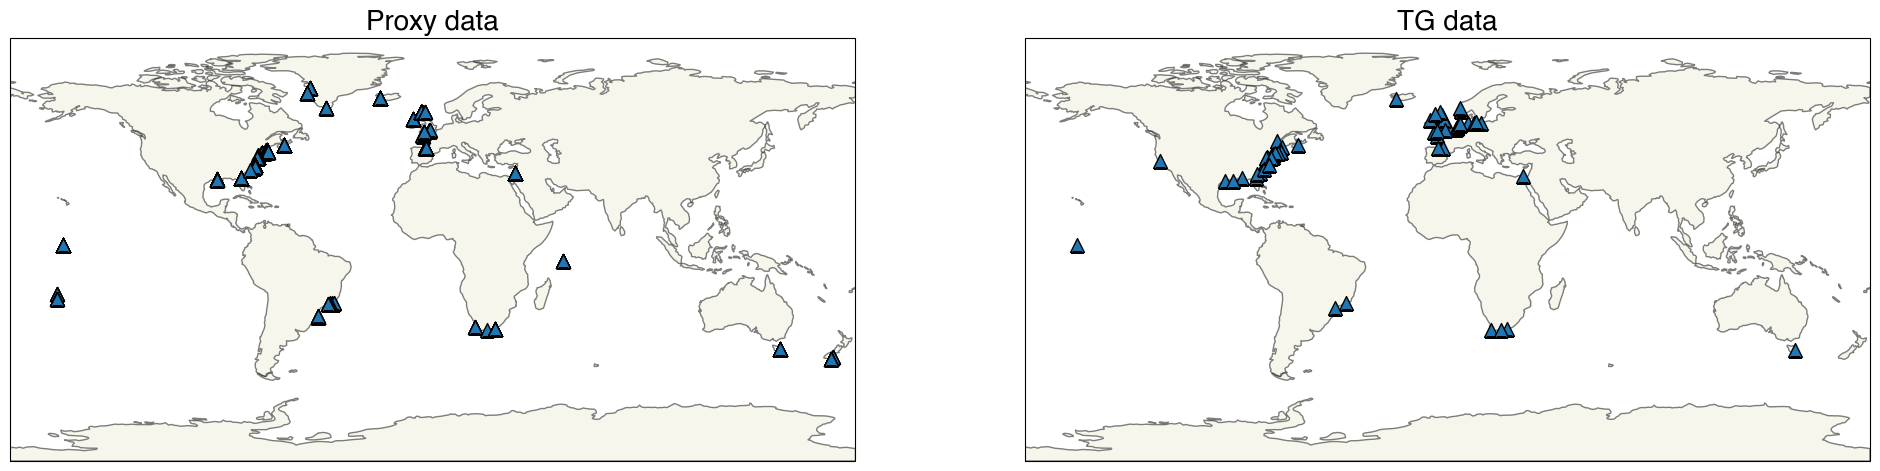

In [12]:
#load the proxy data
proxy_data = pd.read_csv('IFILES/RSL_All_30Dec2015.csv')
trainfirsttime = -1000
proxy_data = proxy_data[proxy_data['Age (CE)']>trainfirsttime]

TG_ID = pd.read_excel('IFILES/TG_ID.xlsx',skiprows=np.arange(1,4))

TG_data_folder = '../../Data/TG_data/'

if len(os.listdir(TG_data_folder))<5:
    with zipfile.ZipFile(TG_data_folder+'TG_data.zip', 'r') as zip_ref:
        zip_ref.extractall(TG_data_folder)
site_file = pd.read_table(TG_data_folder+'/filelist.txt',delimiter=';',header=None)
selection_index = np.array([i in list(TG_ID['PSMSL ID']) for i in site_file.iloc[:,0]])
selected_sites = site_file.iloc[selection_index,:]

plt.figure(figsize=(24,10))
ax2 = plt.subplot(121,projection=ccrs.PlateCarree())
ax2.set_global()
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.scatter(proxy_data['Longitude (E)'],proxy_data['Latitude (N)'],transform=ccrs.PlateCarree(),zorder=1,
            marker='^',s=100,ec='k')
ax2.set_title('Proxy data',fontsize=20)

ax1 = plt.subplot(122,projection=ccrs.PlateCarree())
ax1.set_global()
ax1.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax1.scatter(selected_sites.iloc[:,2],selected_sites.iloc[:,1],transform=ccrs.PlateCarree(),zorder=1,
            marker='^',s=100,ec='k')
ax1.set_title('TG data',fontsize=20);

**Load 1900-2010 global sea-level curve from Hay et al., 2015**


In [13]:
import scipy.io as sio
gslfile = os.path.join('IFILES', 'Hay2015_KFandGP_GMSL.mat')

Haydat = sio.loadmat(gslfile)
Hay = {}

Hay['Y'] = Haydat['KF_GMSL'][0]
Hay['dY'] = np.sqrt(np.diag(Haydat['KF_GMSL_var']))
Hay['Ycv'] = Haydat['KF_GMSL_var']
Hay['datid'] = np.zeros_like(Hay['Y'])
Hay['time1'] = Haydat['tt_KF'][:]
Hay['time2'] = Hay['time1']
Hay['meantime'] = Hay['time1']
Hay['lat'] = np.ones_like(Hay['Y']) * 1e6
Hay['long'] = Hay['lat']
Hay['compactcorr'] = np.zeros_like(Hay['Y'])
Hay['limiting'] = np.zeros_like(Hay['Y'])
Hay['istg'] = np.ones_like(Hay['Y'])
Hay['siteid'] = 0
Hay['sitenames'] = ['Hay_KF_GMSL']
Hay['sitecoords'] = [1e6, 1e6]
Hay['sitelen'] = len(Hay['Y'])

# Smooth Hay et al curve
Hayavgwin = 10
Haystep = 10
HayGSL = Hay.copy()
HayGSL['time1'] = np.arange(1885, 2006, Haystep)
HayGSL['time2'] = HayGSL['time1']
HayGSL['meantime'] = HayGSL['time1']
M = np.abs(np.subtract.outer(HayGSL['time1'], Hay['time1'])) <= (Hayavgwin / 2)
M = M[:,0,:]
M = M / np.sum(M, axis=1, keepdims=True)
HayGSL['Y'] = M @ Hay['Y']
HayGSL['Ycv'] = M @ Hay['Ycv'] @ M.T
HayGSL['dY'] = np.sqrt(np.diag(HayGSL['Ycv']))
HayGSL['datid'] = np.zeros_like(HayGSL['Y'])
HayGSL['lat'] = np.ones_like(HayGSL['Y']) * 1e6
HayGSL['long'] = HayGSL['lat']
HayGSL['compactcorr'] = np.zeros_like(HayGSL['Y'])
HayGSL['limiting'] = np.zeros_like(HayGSL['Y'])
HayGSL['istg'] = np.ones_like(HayGSL['Y'])


**Load global mean sea-level flatter: pseudo data so that average rate of change between -100 to 100 CE and 1600-1800 CE is the same**

In [14]:
GSLflattener = {}
GSLflattener['sigma'] = 1e4
GSLflattener['time1'] = 0.01 + np.concatenate((np.arange(-100, 101, 50), np.arange(1600, 1801, 50)))
GSLflattener['Y'] = np.zeros_like(GSLflattener['time1'])
GSLflattener['Ycv'] = np.ones((len(GSLflattener['Y']), len(GSLflattener['Y']))) * (GSLflattener['sigma']**2)

GSLflattener['Ycv'][:5, :5] += ((0.0025 * 1700)**2 + np.eye(5) * GSLflattener['sigma']**2 - GSLflattener['sigma']**2 / 5)
GSLflattener['Ycv'][5:10, 5:10] += (np.eye(5) * GSLflattener['sigma']**2 - GSLflattener['sigma']**2 / 5)

GSLflattener['dY'] = np.sqrt(np.diag(GSLflattener['Ycv']))
GSLflattener['datid'] = np.zeros_like(GSLflattener['Y'])
GSLflattener['time2'] = GSLflattener['time1']
GSLflattener['meantime'] = GSLflattener['time1']
GSLflattener['lat'] = np.ones_like(GSLflattener['Y']) * 1e6
GSLflattener['long'] = GSLflattener['lat']
GSLflattener['compactcorr'] = np.zeros_like(GSLflattener['Y'])
GSLflattener['limiting'] = np.zeros_like(GSLflattener['Y'])
GSLflattener['istg'] = np.ones_like(GSLflattener['Y'])
GSLflattener['siteid'] = 0
GSLflattener['sitenames'] = ['GSLflattener']
GSLflattener['sitecoords'] = [1e6, 1e6]
GSLflattener['sitelen'] = len(GSLflattener['Y'])


**Load three old TG data**

Check [Kopp et al., 2016](https://www.pnas.org/doi/abs/10.1073/pnas.1517056113) for details.

In [15]:
import os
from scipy.sparse import dia_matrix

# old tide gauges

TGold = {
    'datid': [],
    'meantime': [],
    'Y': [],
    'dY': [],
    'lat': [],
    'long': [],
    'siteid': [],
    'sitenames': [],
    'sitecoords': [],
    'sitelen': [],
    'time1': [],
    'time2': [],
    'limiting': [],
    'compactcorr': [],
    'istg': [],
    'Ycv': None
}

for ppp in range(1, 4):
    if ppp == 1:
        dat = pd.read_csv(os.path.join('IFILES', 'amsterdam.sea.level.txt'), delim_whitespace=True,header=None)
        wsite = 'AMSTERDAM_OLD'
        wcurid = 5001
        wlat = [52.3667]
        wlong = [4.9000]
        wdatid = np.ones(len(dat)) * wcurid
        wtime = dat.iloc[:, 0].values
        wY = dat.iloc[:, 1].values
    elif ppp == 2:
        dat = pd.read_csv(os.path.join('IFILES', 'Kronstadt_ReportsFGI_Bogdanov_appendix.csv'))
        wsite = 'KRONSTADT_OLD'
        wcurid = 5002
        wlat = [59.98]
        wlong = [29.77]
        wdatid = np.ones(len(dat)) * wcurid
        wtime = dat.iloc[:, 0].values
        wY = dat.iloc[:, 2].values
    elif ppp == 3:
        dat = pd.read_csv(os.path.join('IFILES', 'ekman_2003_stockholm.csv'),skiprows=1)
        wsite = 'STOCKHOLM_OLD'
        wcurid = 5003
        wlat = [59.32]
        wlong = [18.08]
        wdatid = np.ones(len(dat)) * wcurid
        wtime = dat.iloc[:, 0].values
        wY = dat.iloc[:, 2].values

    TGold['datid'].extend(wdatid)
    TGold['meantime'].extend(wtime)
    TGold['Y'].extend(wY)
    TGold['dY'] = np.ones(len(TGold['Y'])) * 3
    TGold['lat'].extend(np.ones_like(wY) * wlat)
    TGold['long'].extend(np.ones_like(wY) * wlong)
    TGold['siteid'].extend(np.ones_like(wY) * wcurid)
    TGold['sitenames'].append(wsite)
    TGold['sitecoords'].append([wlat[0], wlong[0]])
    TGold['sitelen'].append(len(wY))

TGold['time1'] = TGold['meantime']
TGold['time2'] = TGold['meantime']
TGold['limiting'] = np.zeros_like(TGold['datid'])
TGold['compactcorr'] = np.zeros_like(TGold['datid'])
TGold['istg'] = np.ones_like(TGold['datid'])
TGold['Ycv'] = dia_matrix((TGold['dY']**2, 0), shape=(len(TGold['Y']), len(TGold['Y'])))


**Smoothing TG data with decadal average**

Tide gaude provides annual relative sea-level measurement, to save computational power as well as let TG data more accurately reflect the recording capabilities of proxy record, we use a simple gaussian process model to convert TG data from annual mean to decadal mean. 

In [16]:
# for idx,i in enumerate(selected_sites.iloc[:,0]):
#     #fit temporal GP to each TG
#     tem_rsl_data = pd.read_table(TG_data_folder+str(i)+'.rlrdata',delimiter=';',header=None)
#     data_filter = tem_rsl_data.iloc[:,1]!=-99999
#     data_filter_2 = tem_rsl_data.iloc[:,2]=='N'
#     data_filter_3 = tem_rsl_data.iloc[:,3]==0
#     data_filter_all = data_filter & data_filter_2 & data_filter_3
#     pyro.clear_param_store()
#     M32_kernel = PSTHM.kernels.Matern32(input_dim=1)
#     M32_kernel.set_prior('variance', dist.Uniform(torch.tensor(30.), torch.tensor(1e6)))
#     M32_kernel.set_prior('lengthscale', dist.Uniform(torch.tensor(30.), torch.tensor(1e6)))

#     TG_noise = torch.ones(len(tem_rsl_data.iloc[:,0][data_filter_all].values))*3.**2
#     GPR = PSTHM.GPRegression_V(torch.tensor(tem_rsl_data.iloc[:,0][data_filter_all].values),torch.tensor(tem_rsl_data.iloc[:,1][data_filter_all].values),M32_kernel,noise = TG_noise)
#     GPR,track_list = PSTHM.SVI_optm(GPR,num_iteration=1000,lr=0.1)
    
#     min_age = tem_rsl_data.iloc[:,0][data_filter_all].min()//10 *10
#     max_age = (tem_rsl_data.iloc[:,0][data_filter_all].max()//10) *10
#     testing_x = np.arange(min_age,max_age+1,1)
#     mean,cov = GPR(torch.tensor(testing_x))
#     mean = mean.detach().numpy()
#     std = cov.sqrt().detach().numpy()
#     #calculate reference RSL at year 2000 by linear regression
#     lr_cof = np.polyfit(tem_rsl_data.iloc[:,0][data_filter_all],tem_rsl_data.iloc[:,1][data_filter_all],1)
#     ref_RSL = lr_cof[0]*2000 + lr_cof[1]
#     #calculate decadal average
#     decadal_x = np.array([np.mean(testing_x[i2*10+1:(i2+1)*10]) for i2 in range(len(testing_x)//10 +1)]) 
#     decadal_mean = np.array([np.mean(mean[i2*10+1:(i2+1)*10]) for i2 in range(len(testing_x)//10 +1)] )
#     decadal_mean_std = np.array([np.mean(std[i2*10+1:(i2+1)*10]) for i2 in range(len(testing_x)//10 +1)])
#     #filter out nan values
#     non_index = np.isnan(decadal_mean)
#     decadal_mean = decadal_mean[~non_index] - ref_RSL
#     decadal_mean_std = decadal_mean_std[~non_index]
#     decadal_x = decadal_x[~non_index]
    
#     if i==1:
#         new_rsl_data= np.array([np.ones(len(decadal_mean))*i,np.ones(len(decadal_mean))*selected_sites.iloc[idx,1],np.ones(len(decadal_mean))*selected_sites.iloc[idx,2],decadal_x,decadal_mean,decadal_mean_std]).T
#     else:
#         new_rsl_data = np.concatenate((new_rsl_data,np.array([np.ones(len(decadal_mean))*i,np.ones(len(decadal_mean))*selected_sites.iloc[idx,1],np.ones(len(decadal_mean))*selected_sites.iloc[idx,2],decadal_x,decadal_mean,decadal_mean_std]).T),axis=0)
# new_rsl_data = pd.DataFrame(new_rsl_data,columns=['ID','Latitude','Longitude','Year (CE)','RSL (mm)','RSL std (mm)'])
# new_rsl_data.to_csv('IFILES/Decadal_TG.csv',index=False)
new_TG_rsl_data = pd.read_csv('IFILES/Decadal_TG.csv')

**Smoothing old TG data with decadal average**

In [17]:
# #Do GP regression for three sites
# old_TG_x = torch.tensor(TGold['meantime'])
# old_TG_y = torch.tensor(TGold['Y'])
# old_TG_x_sigma = torch.zeros_like(old_TG_x)
# old_TG_y_sigma = torch.tensor(TGold['dY'])

# for i in np.unique(TGold['datid']):
#     idx = TGold['datid'] == i
#     test_x = old_TG_x[idx]
#     test_y = old_TG_y[idx]
#     test_x_sigma = old_TG_x_sigma[idx]
#     test_y_sigma = old_TG_y_sigma[idx]
#     test_lon = np.array(TGold['long'])[idx][0]
#     test_lat = np.array(TGold['lat'])[idx][0]

#     pyro.clear_param_store()
#     M32_kernel = PSTHM.kernels.Matern32(input_dim=1)
#     M32_kernel.set_prior('variance', dist.Uniform(torch.tensor(30.), torch.tensor(1e6)))
#     M32_kernel.set_prior('lengthscale', dist.Uniform(torch.tensor(30.), torch.tensor(1e6)))

#     GPR = PSTHM.GPRegression_V(test_x,test_y,M32_kernel,noise = test_y_sigma**2)
#     GPR,track_list = PSTHM.SVI_optm(GPR,num_iteration=1000,lr=0.1)

#     min_age = test_x.min()//10 *10
#     max_age = (test_x.max()//10) *10
#     testing_x = np.arange(min_age,max_age+1,1)
#     mean,cov = GPR(torch.tensor(testing_x))
#     mean = mean.detach().numpy()
#     std = cov.sqrt().detach().numpy()

#     #calculate decadal average
#     decadal_x = np.array([np.mean(testing_x[i2*10+1:(i2+1)*10]) for i2 in range(len(testing_x)//10 +1)]) 
#     decadal_mean = np.array([np.mean(mean[i2*10+1:(i2+1)*10]) for i2 in range(len(testing_x)//10 +1)] )
#     decadal_mean_std = np.array([np.mean(std[i2*10+1:(i2+1)*10]) for i2 in range(len(testing_x)//10 +1)])
#     #filter out nan values
#     non_index = np.isnan(decadal_mean)
#     decadal_mean = decadal_mean[~non_index] 
#     decadal_mean_std = decadal_mean_std[~non_index]
#     decadal_x = decadal_x[~non_index]

#     if i==5001:
#         old_TG_rsl_data= np.array([np.ones(len(decadal_mean))*i,np.ones(len(decadal_mean))*test_lat,np.ones(len(decadal_mean))*test_lon,decadal_x,decadal_mean,decadal_mean_std]).T
#     else:
#         old_TG_rsl_data = np.concatenate((old_TG_rsl_data, np.array([np.ones(len(decadal_mean))*i,np.ones(len(decadal_mean))*test_lat,np.ones(len(decadal_mean))*test_lon,decadal_x,decadal_mean,decadal_mean_std]).T),axis=0)

# old_TG_rsl_data = pd.DataFrame(old_TG_rsl_data,columns=['ID','Latitude','Longitude','Year (CE)','RSL (mm)','RSL std (mm)'])
# old_TG_rsl_data.to_csv('IFILES/Decadal_old_TG.csv',index=False)
old_TG_rsl_data = pd.read_csv('IFILES/Decadal_old_TG.csv')

**Combine all data**


In [18]:
#combined proxy and TG data 

X = np.hstack((proxy_data['Age (CE)'],new_TG_rsl_data['Year (CE)'],old_TG_rsl_data['Year (CE)'],GSLflattener['meantime'],HayGSL['meantime']))
y = np.hstack((proxy_data['RSL (m)'],new_TG_rsl_data['RSL (mm)']/1000,old_TG_rsl_data['RSL (mm)']/1000,
                GSLflattener['Y']/1000,HayGSL['Y']/1000))
proxy_x_sigma = (proxy_data['Age +2s'] + proxy_data['Age -2s'])/4
X_sigma = np.hstack((proxy_x_sigma,np.zeros(len(new_TG_rsl_data)),np.zeros(len(old_TG_rsl_data)),
                    np.zeros(len(GSLflattener['meantime'])),np.zeros(len(HayGSL['meantime']))))

proxy_y_sigma = (proxy_data['RSL +1s'] + proxy_data['RSL -1s'])/2
y_sigma = np.hstack((proxy_y_sigma,new_TG_rsl_data['RSL std (mm)']/1000,
                    old_TG_rsl_data['RSL std (mm)']/1000,GSLflattener['dY']/1000,HayGSL['dY']/1000))

longitude = np.hstack([proxy_data['Longitude (E)'],new_TG_rsl_data['Longitude'],old_TG_rsl_data['Longitude'],
                    GSLflattener['long']/200,HayGSL['long']/2000])
longitude[longitude<0]+=360
latitude = np.hstack([proxy_data['Latitude (N)'],new_TG_rsl_data['Latitude'],old_TG_rsl_data['Latitude'],
                    GSLflattener['lat']/200,HayGSL['lat']/2000])

X_all = np.vstack([X,latitude,longitude]).T

#filter out data with too old age or too large uncertainty
filter_1 = (X<-1000) &(X>2010)
filter_2 = X_sigma>=100
filter_all = filter_1 | filter_2
X = X[~filter_all]
y = y[~filter_all]
X_sigma = X_sigma[~filter_all]
y_sigma = y_sigma[~filter_all]
X_all = X_all[~filter_all]
longitude = longitude[~filter_all]
latitude = latitude[~filter_all]


#### 2. Load ICE5G Model

Vertical land motion predictions from ICE5G is used as the prior for linear kernel. In this case, we are modelling 

In [19]:
#load ICE5G
import netCDF4 as nc
nc = nc.Dataset('IFILES/dsea250.1grid.ICE5Gv1.3_VM2_L90_2012.nc')
lon = nc.variables['Lon'][:]
lat = nc.variables['Lat'][:]
Lon_mat,Lat_mat = np.meshgrid(lon,lat)
GIA = nc.variables['Dsea_250'][:]

#interpolate ICE5G linear rate to all sites
from scipy import interpolate
long_index = longitude<360

GIA_rate = interpolate.griddata(np.vstack([Lon_mat.flatten(),Lat_mat.flatten()]).T, GIA.flatten(), (longitude[long_index], latitude[long_index]), method='linear')

y_no_GIA = y.copy()
y_no_GIA[long_index] = y_no_GIA[long_index] - GIA_rate*(X[long_index]-2010)/1000

#### 3. Fit Spatio-temporal GP

Here we first try to use PaleoSTeHM to perform maximum likelihood estimate and then use the hyperparamters provided by Kopp et al., 2016. You can run the code below, which takes around 2 minutes, or you can just load the trained model by PaleoSTeHM. 

In [11]:
# filter out data with poor quality

pyro.clear_param_store()
#define global temporal kernel
global_kernel = PSTHM.kernels.Matern32 (input_dim=1,geo=False)
global_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(10.), torch.tensor(100.)))
global_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-4), torch.tensor(1.)))

#define regionally linar spatio-temporal kernel
regional_linear_temporal_kernel = PSTHM.kernels.Linear(input_dim=1)
regional_linear_temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-12), torch.tensor(10.)))
regional_linear_temporal_kernel.ref_year = torch.tensor(2010.)
regional_linear_spatial_kernel = PSTHM.kernels.Matern21(input_dim=1,geo=True)
regional_linear_spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.01), torch.tensor(0.15)))
regional_linear_kernel = PSTHM.kernels.Product(regional_linear_temporal_kernel, regional_linear_spatial_kernel)

#define regionally non-linar spatio-temporal kernel
regional_nl_temporal_kernel = PSTHM.kernels.Matern32(input_dim=1,lengthscale =global_kernel.lengthscale,geo=False)
regional_nl_temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-6), torch.tensor(3e-2)))
regional_nl_spatial_kernel = PSTHM.kernels.Matern21(input_dim=1,geo=True)
regional_nl_spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.02), torch.tensor(0.15)))
regional_nl_kernel = PSTHM.kernels.Product(regional_nl_temporal_kernel, regional_nl_spatial_kernel)

#site specific datum correction
sp_whitenoise_kernel = PSTHM.kernels.WhiteNoise_SP(input_dim=1,sp=False,geo=True)
sp_whitenoise_kernel.set_prior('variance',dist.Uniform(torch.tensor(1e-7),torch.tensor(1e-3)))

#whitenoise error
whitenoise_kernel = PSTHM.kernels.WhiteNoise(input_dim=1)
whitenoise_kernel.set_prior('variance',dist.Uniform(torch.tensor(1e-7),torch.tensor(1e-3)))

constant_kernel = PSTHM.kernels.Constant(input_dim=1)
constant_kernel.set_prior('variance',dist.Uniform(torch.tensor(1e-7),torch.tensor(1e-1)))

combined_sp_kernel = PSTHM.kernels.Sum(global_kernel,regional_linear_kernel)
combined_sp_kernel = PSTHM.kernels.Sum(combined_sp_kernel,regional_nl_kernel)
combined_sp_kernel = PSTHM.kernels.Sum(combined_sp_kernel,sp_whitenoise_kernel)
combined_sp_kernel = PSTHM.kernels.Sum(combined_sp_kernel,whitenoise_kernel)
combined_sp_kernel = PSTHM.kernels.Sum(combined_sp_kernel,constant_kernel)

N = len(X_all)
noise_cov = torch.zeros(N,N).double()
noise_cov.view(-1)[:: N + 1] += 1e-5 + torch.tensor(y_sigma**2)
noise_cov[np.outer(longitude>500,longitude>500)] = torch.tensor(GSLflattener['Ycv']/1000**2).flatten()
noise_cov[np.outer((longitude>360) &(longitude<501) ,(longitude>360) &(longitude<501))] =  torch.tensor(HayGSL['Ycv']/1000**2).flatten()

gpr = PSTHM.model.GPRegression_V(torch.tensor(X_all), torch.tensor(y_no_GIA), combined_sp_kernel,noise=noise_cov,jitter=1e-5)

# Empirical bayes optimization, default iteration is 1000
#here we set the lengthscale for global kernel to be equal to the lengthscale for regional non-linear kernel
# gpr,track_list = PSTHM.opti.SVI_NI_optm(gpr,x_sigma=torch.tensor(X_sigma),num_iteration=100,lr=0.5,decay_r = 0.8,step_size=10,equal_kernels=[['kernel.kern0.kern0.kern0.kern1.kern0.lengthscale','kernel.kern0.kern0.kern0.kern0.kern0.lengthscale']])
# PSTHM.plotting.plot_track_list(track_list)

# pyro.get_param_store().save("IFILES/Kopp_et_al_2016_GMSL_model.pt")

pyro.get_param_store().load("IFILES/Kopp_et_al_2016_GMSL_model.pt")


In [12]:
# regional_linear_temporal_kernel.ref_year = 2010.
test_age = np.arange(-1000,2020,10)
#generate prediction for one location
data_point = X_all[300,1:]
pred_matrix = PSTHM.post.gen_pred_matrix(test_age,*data_point)
y_mean, y_var = gpr(pred_matrix, full_cov=True)
y_std = y_var.diag().sqrt()
#-----------------define the kernel to decompose-----------------
test_global_kernel =   PSTHM.kernels.Sum(gpr.kernel.kern0.kern0.kern0.kern0.kern0,gpr.kernel.kern1)
regional_linear_kernel =gpr.kernel.kern0.kern0.kern0.kern0.kern1
regional_nl_kernel = gpr.kernel.kern0.kern0.kern0.kern1

#-----------------decompose the kernel-----------------
global_dep,reigonal_linear_dep,regional_nl_dep = PSTHM.post.decompose_kernels(gpr,pred_matrix,[test_global_kernel,regional_linear_kernel,regional_nl_kernel])
global_mean,global_var = global_dep
global_std = global_var.diag().sqrt()

regional_linear_mean,regional_linear_var = reigonal_linear_dep
regional_linear_std = regional_linear_var.diag().sqrt()

regional_nl_mean,regional_nl_var = regional_nl_dep
regional_nl_std = regional_nl_var.diag().sqrt()



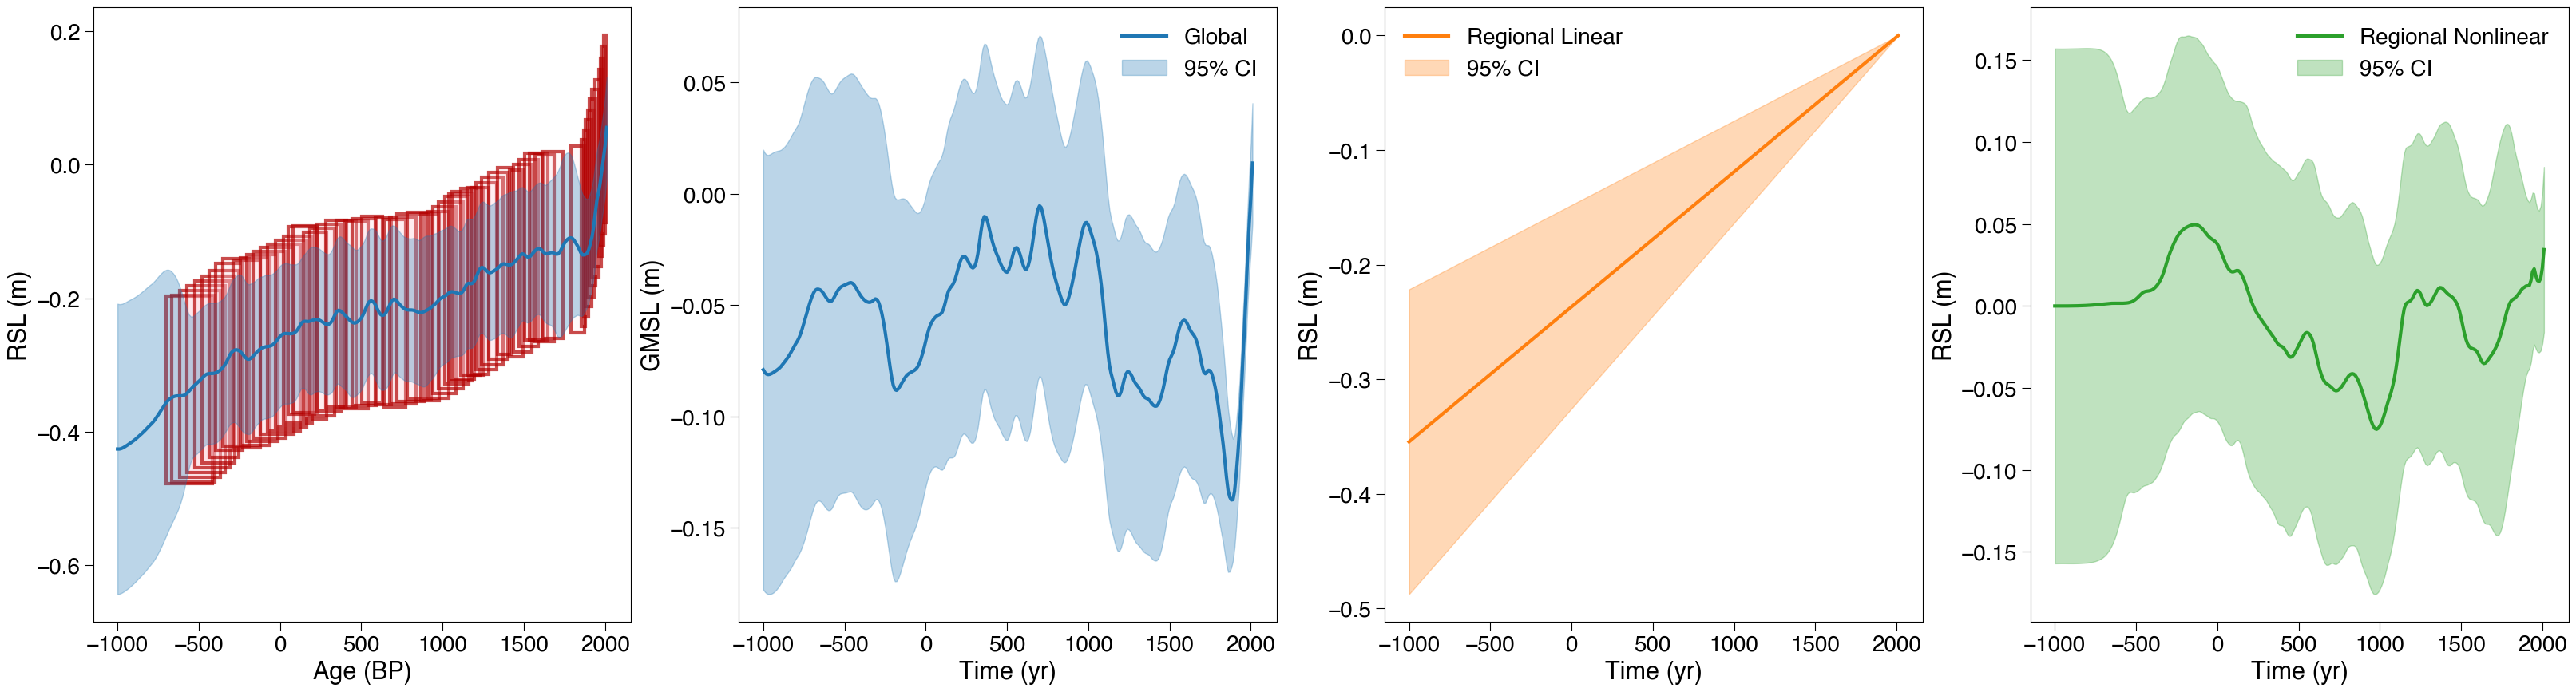

In [13]:
plt.figure(figsize=(40,10))
ax = plt.subplot(141)
data_index = np.sum(np.abs(X_all[:,1:]-data_point),axis=1)<1e-3
PSTHM.plotting.plot_uncertainty_boxes(X_all[:,0][data_index],y_no_GIA[data_index], X_sigma[data_index]*2,y_sigma[data_index]*2,ax=ax)
plt.plot(pred_matrix[:,0],y_mean.detach().numpy(),'C0',linewidth=3,label='Mean Prediction')
plt.fill_between(pred_matrix[:,0],y_mean.detach().numpy()-2*y_std.detach().numpy(),y_mean.detach().numpy()+2*y_std.detach().numpy(),color='C0',alpha=0.3,label='95% CI')
plt.subplot(142)
plt.plot(test_age,global_mean.detach().numpy(),'C0',linewidth=3,label='Global')
plt.fill_between(test_age,global_mean.detach().numpy()-2*global_std.detach().numpy(),global_mean.detach().numpy()+2*global_std.detach().numpy(),color='C0',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('GMSL (m)')
plt.legend()
plt.subplot(143)
plt.plot(test_age,regional_linear_mean.detach().numpy(),'C1',linewidth=3,label='Regional Linear')
plt.fill_between(test_age,regional_linear_mean.detach().numpy()-2*regional_linear_std.detach().numpy(),regional_linear_mean.detach().numpy()+2*regional_linear_std.detach().numpy(),color='C1',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (m)')
plt.legend()
plt.subplot(144)
plt.plot(test_age,regional_nl_mean.detach().numpy(),'C2',linewidth=3,label='Regional Nonlinear')
plt.fill_between(test_age,regional_nl_mean.detach().numpy()-2*regional_nl_std.detach().numpy(),regional_nl_mean.detach().numpy()+2*regional_nl_std.detach().numpy(),color='C2',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (m)')
plt.legend()

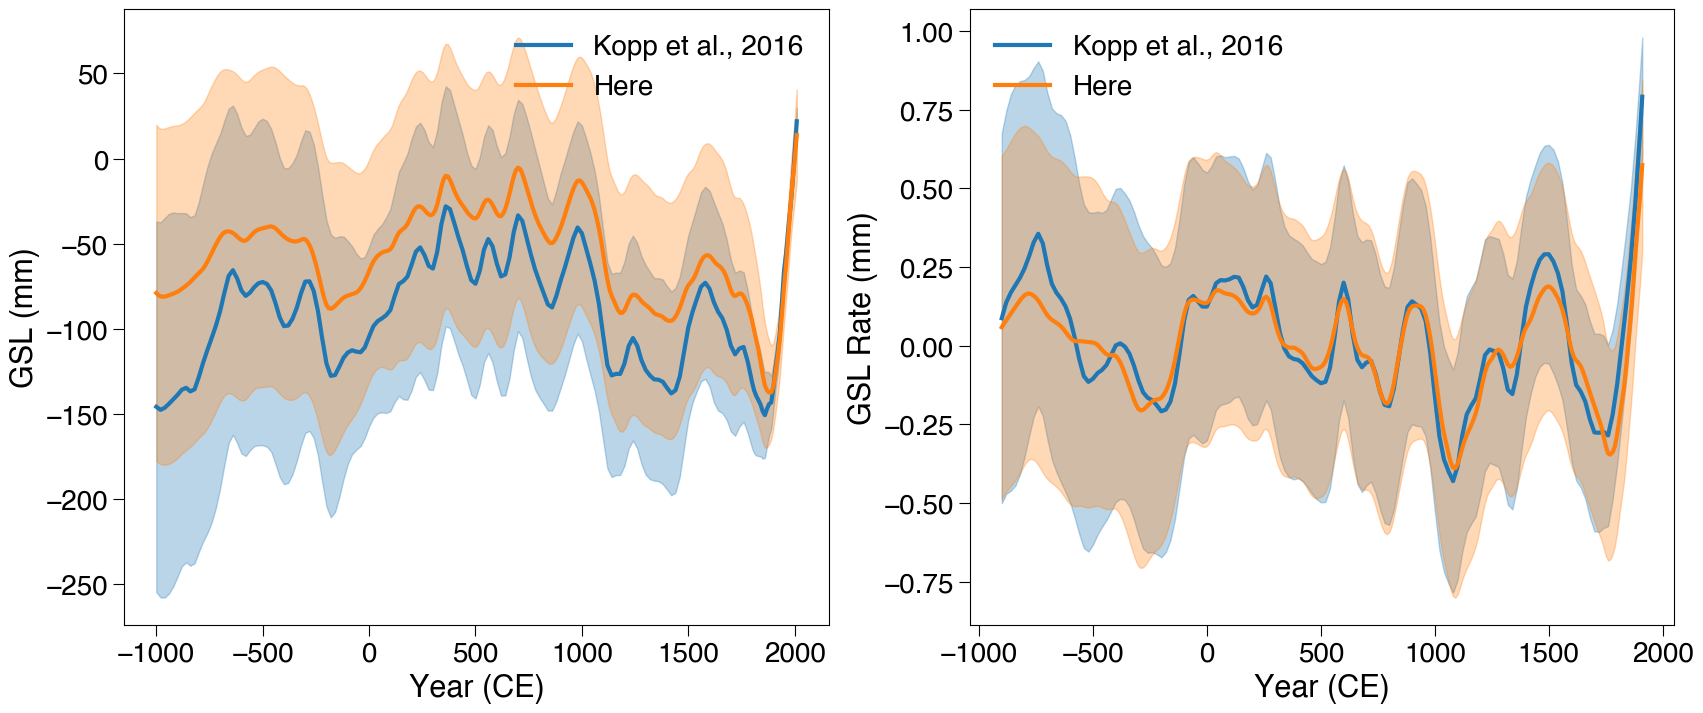

In [14]:
kopp2016 = pd.read_excel('IFILES/Kopp2016.xls',sheet_name=1,skiprows=2)
kopp2016_cov = pd.read_excel('IFILES/Kopp2016.xls',sheet_name=6,skiprows=2).iloc[:,1:]
rsl_time,rsl_rate,rsl_rate_sd = PSTHM.post.cal_rate_var(pred_matrix[:,0].detach().numpy(),global_var.detach().numpy(),global_mean.detach().numpy())
kopp2016_rsl_time,kopp2016_rsl_rate,kopp2016_rsl_rate_sd = PSTHM.post.cal_rate_var(kopp2016['Year'].values,kopp2016_cov,kopp2016['mm'])

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.plot(kopp2016['Year'], kopp2016['mm'],label='Kopp et al., 2016',lw=3)
plt.fill_between(kopp2016['Year'],kopp2016['mm']+2*kopp2016['1s'],kopp2016['mm']-2*kopp2016['1s'],alpha=0.3,color='C0')

plt.plot(test_age,global_mean.detach().numpy()*1000,linewidth=3,label='Here')
plt.fill_between(test_age,(global_mean.detach().numpy()-2*global_std.detach().numpy())*1000,(global_mean.detach().numpy()+2*global_std.detach().numpy())*1000,color='C1',alpha=0.3)
plt.ylabel('GSL (mm)')
plt.xlabel('Year (CE)')
plt.legend()

plt.subplot(122)
plt.plot(kopp2016_rsl_time,kopp2016_rsl_rate,label='Kopp et al., 2016',lw=3)
plt.fill_between(kopp2016_rsl_time,kopp2016_rsl_rate+2*kopp2016_rsl_rate_sd,kopp2016_rsl_rate-2*kopp2016_rsl_rate_sd,alpha=0.3,color='C0')
plt.plot(rsl_time,rsl_rate*1000,label='Here',lw=3)
plt.fill_between(rsl_time,(rsl_rate-2*rsl_rate_sd)*1000,(rsl_rate+2*rsl_rate_sd)*1000,alpha=0.3,color='C1')
plt.ylabel('GSL Rate (mm)')
plt.xlabel('Year (CE)')
plt.legend()

**Using the hyperparameters from Kopp et al., 2016**

In [15]:
pyro.clear_param_store()

gpr.kernel.kern0.kern0.kern0.kern0.kern0.variance = 0.0032832899999999995
gpr.kernel.kern0.kern0.kern0.kern0.kern0.lengthscale = 100

gpr.kernel.kern0.kern0.kern0.kern0.kern1.kern0.variance=1.21e-06
gpr.kernel.kern0.kern0.kern0.kern0.kern1.kern1.s_lengthscale=0.09599310885968812

gpr.kernel.kern0.kern0.kern0.kern1.kern1.s_lengthscale = 0.1117010721276371
gpr.kernel.kern0.kern0.kern0.kern1.kern0.variance = 0.00259081
gpr.kernel.kern0.kern0.kern0.kern1.kern0.lengthscale = 100

gpr.kernel.kern0.kern1.variance = torch.tensor(0.00032761000000000004)
gpr.kernel.kern0.kern0.kern1.variance = torch.tensor(0.00043680999999999993)
gpr.kernel.kern1.variance = torch.tensor(0.014641)

In [16]:
#calculate sea-level change with new hyperparameters
gpr.y = torch.tensor(y_no_GIA)

test_age = np.arange(-1000,2020,10)
#generate prediction for one location
data_point = X_all[100,1:]
pred_matrix = PSTHM.post.gen_pred_matrix(test_age,*data_point)
y_mean, y_var = gpr(pred_matrix, full_cov=True)
y_std = y_var.diag().sqrt()
#-----------------define the kernel to decompose-----------------
test_global_kernel =   PSTHM.kernels.Sum(gpr.kernel.kern0.kern0.kern0.kern0.kern0,gpr.kernel.kern1)
regional_linear_kernel =gpr.kernel.kern0.kern0.kern0.kern0.kern1
regional_nl_kernel = gpr.kernel.kern0.kern0.kern0.kern1

#-----------------decompose the kernel-----------------
global_dep,reigonal_linear_dep,regional_nl_dep = PSTHM.post.decompose_kernels(gpr,pred_matrix,[test_global_kernel,regional_linear_kernel,regional_nl_kernel])
global_mean,global_var = global_dep
global_std = global_var.diag().sqrt()

regional_linear_mean,regional_linear_var = reigonal_linear_dep
regional_linear_std = regional_linear_var.diag().sqrt()

regional_nl_mean,regional_nl_var = regional_nl_dep
regional_nl_std = regional_nl_var.diag().sqrt()



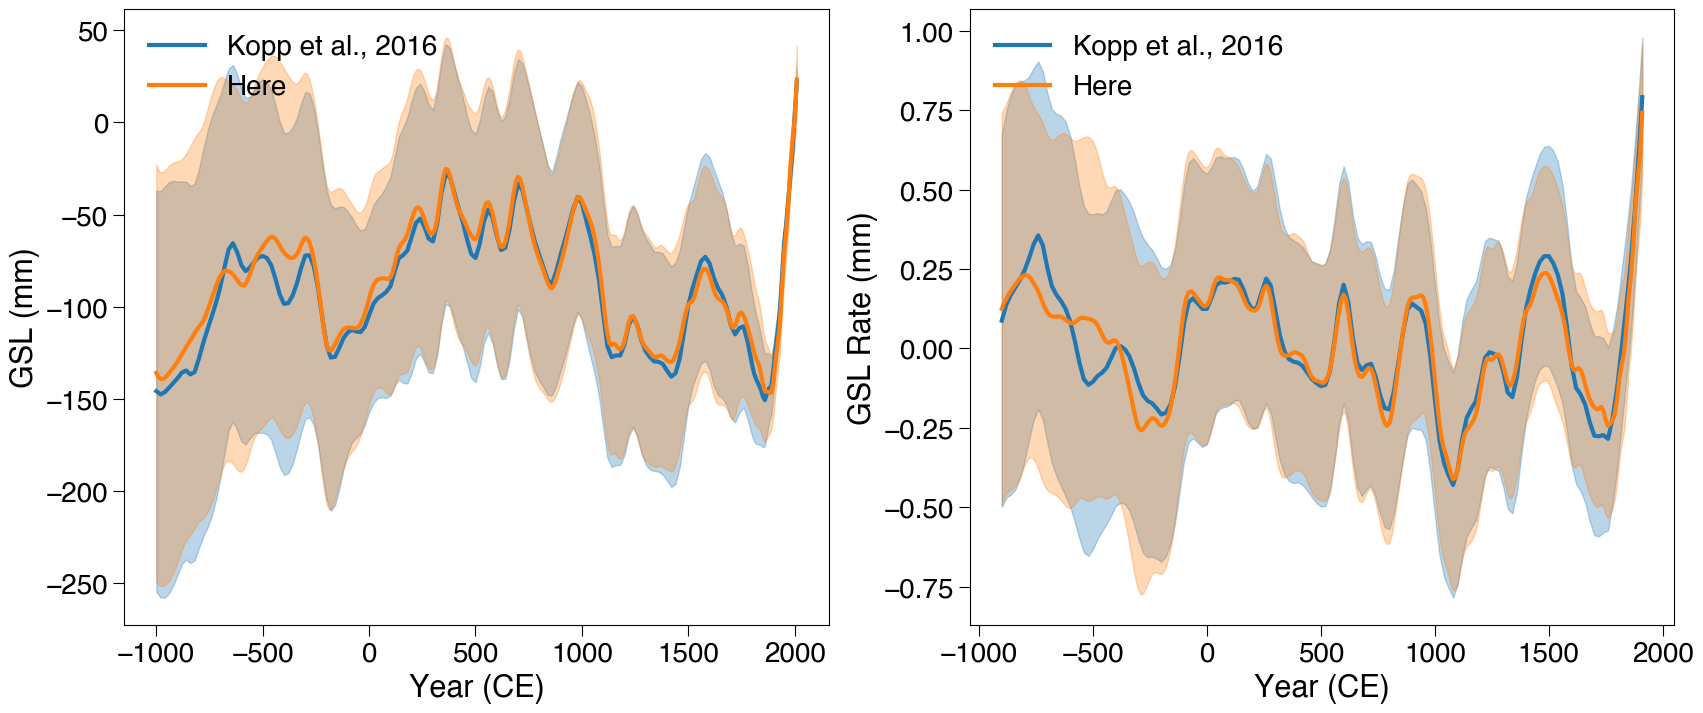

In [17]:
kopp2016 = pd.read_excel('IFILES/Kopp2016.xls',sheet_name=1,skiprows=2)
kopp2016_cov = pd.read_excel('IFILES/Kopp2016.xls',sheet_name=6,skiprows=2).iloc[:,1:]
rsl_time,rsl_rate,rsl_rate_sd = PSTHM.post.cal_rate_var(pred_matrix[:,0].detach().numpy(),global_var.detach().numpy(),global_mean.detach().numpy())
kopp2016_rsl_time,kopp2016_rsl_rate,kopp2016_rsl_rate_sd = PSTHM.post.cal_rate_var(kopp2016['Year'].values,kopp2016_cov,kopp2016['mm'])

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.plot(kopp2016['Year'], kopp2016['mm'],label='Kopp et al., 2016',lw=3)
plt.fill_between(kopp2016['Year'],kopp2016['mm']+2*kopp2016['1s'],kopp2016['mm']-2*kopp2016['1s'],alpha=0.3,color='C0')

plt.plot(test_age,global_mean.detach().numpy()*1000,linewidth=3,label='Here')
plt.fill_between(test_age,(global_mean.detach().numpy()-2*global_std.detach().numpy())*1000,(global_mean.detach().numpy()+2*global_std.detach().numpy())*1000,color='C1',alpha=0.3)
plt.ylabel('GSL (mm)')
plt.xlabel('Year (CE)')
plt.legend()

plt.subplot(122)
plt.plot(kopp2016_rsl_time,kopp2016_rsl_rate,label='Kopp et al., 2016',lw=3)
plt.fill_between(kopp2016_rsl_time,kopp2016_rsl_rate+2*kopp2016_rsl_rate_sd,kopp2016_rsl_rate-2*kopp2016_rsl_rate_sd,alpha=0.3,color='C0')
plt.plot(rsl_time,rsl_rate*1000,label='Here',lw=3)
plt.fill_between(rsl_time,(rsl_rate-2*rsl_rate_sd)*1000,(rsl_rate+2*rsl_rate_sd)*1000,alpha=0.3,color='C1')
plt.ylabel('GSL Rate (mm)')
plt.xlabel('Year (CE)')
plt.legend()

#### 4. Replicate key metrices provided in Kopp et al., 2016


- Global sea level (GSL) rose 0.1 +/- 0.1 mm/yr over 0-700 CE. 
- GSL fall of 0.2 +/- 0.2 mm/y over 1000-1400 CE. 


In [18]:
gpr.y = torch.tensor(y)
test_age = [0,700,1000,1400]
#generate prediction for one location
data_point = X_all[100,1:]
pred_matrix = PSTHM.post.gen_pred_matrix(test_age,*data_point)
test_global_kernel =   PSTHM.kernels.Sum(gpr.kernel.kern0.kern0.kern0.kern0.kern0,gpr.kernel.kern1)
global_dep = PSTHM.post.decompose_kernels(gpr,pred_matrix,[test_global_kernel])
global_mean,global_var = global_dep[0]
global_std = global_var.diag().sqrt()

print('0-700 CE GSL rate: {:5.2f} +/- {:5.2f} mm/yr'.format((global_mean[1]-global_mean[0])/700*1000,np.sqrt(global_std[0]**2 + global_std[1]**2) / 700 *1000*2))
print('1000-1400 CE GSL rate: {:5.2f} +/- {:5.2f} mm/yr'.format((global_mean[3]-global_mean[2])/400*1000,np.sqrt(global_std[3]**2 + global_std[2]**2) /400*1000*2))

0-700 CE GSL rate:  0.09 +/-  0.13 mm/yr
1000-1400 CE GSL rate: -0.22 +/-  0.22 mm/yr


**Sea-level change rate between 1900 to 2000 CE**

In [30]:
lat_matrix = np.arange(-90,90,3) # 3 degree spatial resolution
lon_matrix = np.arange(3,363,3)
lon_mat,lat_mat = np.meshgrid(lon_matrix,lat_matrix)
pred_matrix = PSTHM.post.gen_pred_matrix([1900],lat_matrix,lon_matrix)
pred_matrix2 = PSTHM.post.gen_pred_matrix([2000],lat_matrix,lon_matrix)
y_mean, y_var = gpr(pred_matrix, full_cov=True)
y_mean_2, y_var_2 = gpr(pred_matrix2, full_cov=True)

reduce_variance_index1 = y_var.diag().reshape(lon_mat.shape)<(y_var.diag().max()*0.9)
reduce_variance_index2 = y_var_2.diag().reshape(lon_mat.shape)<(y_var_2.diag().max()*0.9)
reduce_variance_index = reduce_variance_index1 & reduce_variance_index2

GIA_rate_pred = interpolate.griddata(np.vstack([Lon_mat.flatten(),Lat_mat.flatten()]).T, GIA.flatten(), (lon_mat.flatten(), lat_mat.flatten()), method='linear')

Text(0.5, 1.0, 'GSL rate 1900-2000 CE: 1.4 +/- 0.2 mm/yr')

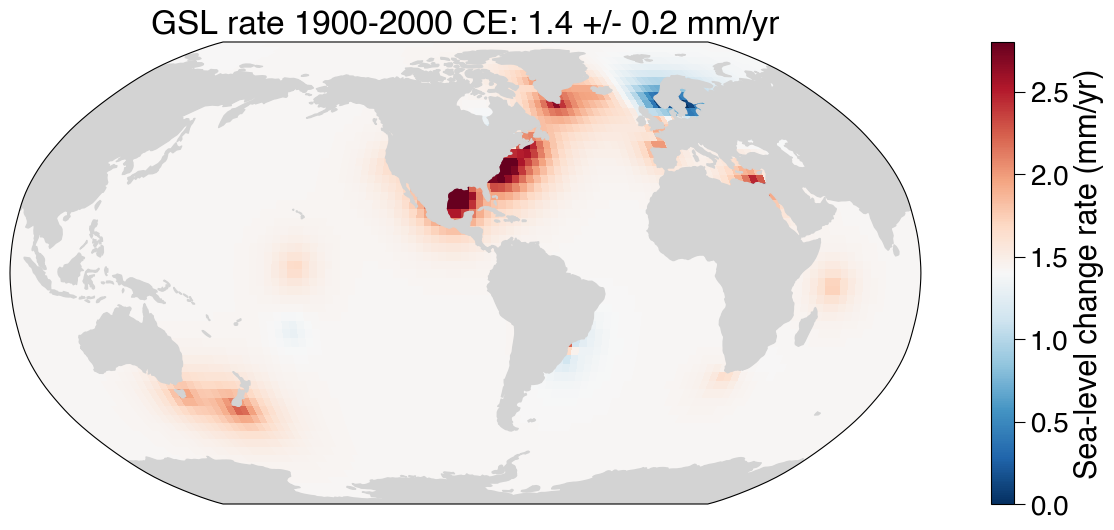

In [20]:
plt.figure(figsize=(18,6))
ax2 = plt.subplot(111,projection=ccrs.Robinson(central_longitude=270))
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,color='lightgrey')
im = ax2.pcolor(lon_mat,lat_mat,(y_mean_2-y_mean).reshape(lon_mat.shape)/100*1000 ,cmap='RdBu_r',transform=ccrs.PlateCarree(),zorder=-1,vmax=2.8,vmin=0)
ax2.set_global()
plt.colorbar(im,label='Sea-level change rate (mm/yr)')
plt.title('GSL rate 1900-2000 CE: 1.4 +/- 0.2 mm/yr')

### Application Example2: Walker et al., 2022 Timing of emergence of modern rates of sea-level rise by 1863



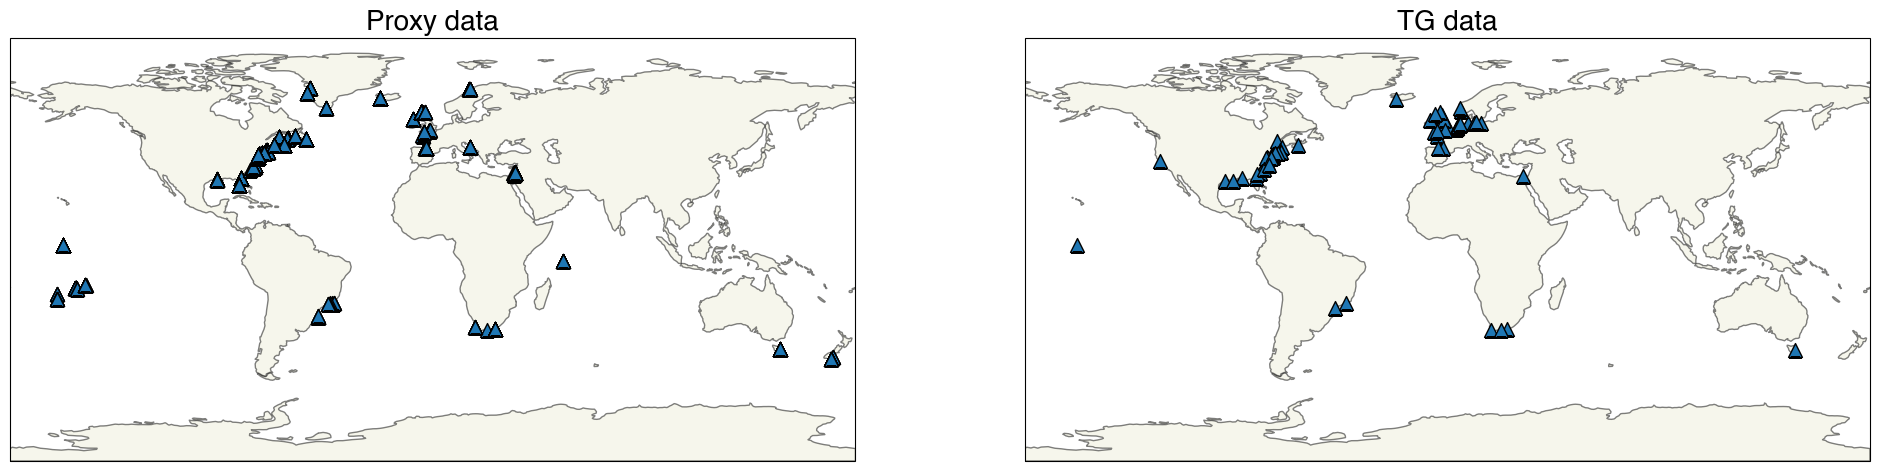

In [20]:

#load the proxy data
proxy_data = pd.read_csv('IFILES/RSL_All_17Mar2020.tsv', sep='\t', header=0, encoding= 'unicode_escape')

trainfirsttime = -4000
proxy_data = proxy_data[proxy_data['Age (CE)']>trainfirsttime]

plt.figure(figsize=(24,10))
ax2 = plt.subplot(121,projection=ccrs.PlateCarree())
ax2.set_global()
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.scatter(proxy_data['Longitude (¡E)'],proxy_data['Latitude (¡N)'],transform=ccrs.PlateCarree(),zorder=1,
            marker='^',s=100,ec='k')
ax2.set_title('Proxy data',fontsize=20)

ax1 = plt.subplot(122,projection=ccrs.PlateCarree())
ax1.set_global()
ax1.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax1.scatter(selected_sites.iloc[:,2],selected_sites.iloc[:,1],transform=ccrs.PlateCarree(),zorder=1,
            marker='^',s=100,ec='k')
ax1.set_title('TG data',fontsize=20);

In [21]:
#combined proxy and TG data 

X = np.hstack((proxy_data['Age (CE)'],new_TG_rsl_data['Year (CE)'],old_TG_rsl_data['Year (CE)'],HayGSL['meantime']))
y = np.hstack((proxy_data['RSL (m)'],new_TG_rsl_data['RSL (mm)']/1000,old_TG_rsl_data['RSL (mm)']/1000,HayGSL['Y']/1000))
proxy_x_sigma = (proxy_data['Age +2s'] + proxy_data['Age -2s'])/4
X_sigma = np.hstack((proxy_x_sigma,np.zeros(len(new_TG_rsl_data)),np.zeros(len(old_TG_rsl_data)),np.zeros(len(HayGSL['meantime']))))

proxy_y_sigma = (proxy_data['RSL +1s'] + proxy_data['RSL -1s'])/2
y_sigma = np.hstack((proxy_y_sigma,new_TG_rsl_data['RSL std (mm)']/1000,
                    old_TG_rsl_data['RSL std (mm)']/1000,HayGSL['dY']/1000))

longitude = np.hstack([proxy_data['Longitude (¡E)'],new_TG_rsl_data['Longitude'],old_TG_rsl_data['Longitude'],HayGSL['long']/2000])
longitude[longitude<0]+=360
latitude = np.hstack([proxy_data['Latitude (¡N)'],new_TG_rsl_data['Latitude'],old_TG_rsl_data['Latitude'],HayGSL['lat']/2000])

X_all = np.vstack([X,latitude,longitude]).T

#filter out data with too old age or too large uncertainty
filter_1 = (X<-5000) &(X>2030)
filter_2 = X_sigma>=100
filter_all = filter_1 | filter_2
X = X[~filter_all]
y = y[~filter_all]
X_sigma = X_sigma[~filter_all]
y_sigma = y_sigma[~filter_all]
X_all = X_all[~filter_all]
longitude = longitude[~filter_all]
latitude = latitude[~filter_all]


In [22]:
#load ICE5G
import netCDF4 as nc
nc = nc.Dataset('IFILES/dsea250.1grid.ICE5Gv1.3_VM2_L90_2012.nc')
lon = nc.variables['Lon'][:]
lat = nc.variables['Lat'][:]
Lon_mat,Lat_mat = np.meshgrid(lon,lat)
GIA = nc.variables['Dsea_250'][:]

#interpolate ICE5G linear rate to all sites
from scipy import interpolate
long_index = longitude<360

GIA_rate = interpolate.griddata(np.vstack([Lon_mat.flatten(),Lat_mat.flatten()]).T, GIA.flatten(), (longitude[long_index], latitude[long_index]), method='linear')

y_no_GIA = y.copy()
mean_GIA = GIA_rate*(X[long_index]-2010)/1000
y_no_GIA[long_index] = y_no_GIA[long_index] - mean_GIA

In [23]:
import pyro.contrib.gp as gp

# filter out data with poor quality

pyro.clear_param_store()
#define global temporal kernel fast
global_kernel_f = PSTHM.kernels.Matern32(input_dim=1,geo=False)
#define global temporal kernel slow
global_kernel_s = PSTHM.kernels.Matern32(input_dim=1,geo=False)

#define regionally linar spatio-temporal kernel
regional_linear_temporal_kernel = PSTHM.kernels.Linear(input_dim=1)
regional_linear_temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-12), torch.tensor(10.)))
regional_linear_temporal_kernel.ref_year = torch.tensor(2010.)

regional_linear_spatial_kernel = PSTHM.kernels.Matern21(input_dim=1,geo=True)
regional_linear_kernel = PSTHM.kernels.Product(regional_linear_temporal_kernel, regional_linear_spatial_kernel)

#define fast regionally non-linar spatio-temporal kernel 
regional_nl_temporal_kernel_f = PSTHM.kernels.Matern32(input_dim=1,lengthscale =global_kernel_f.lengthscale,geo=False)
regional_nl_spatial_kernel_f = PSTHM.kernels.Matern21(input_dim=1,geo=True)
regional_nl_kernel_f = PSTHM.kernels.Product(regional_nl_temporal_kernel_f, regional_nl_spatial_kernel_f)

#define slow regionally non-linar spatio-temporal kernel 
regional_nl_temporal_kernel_s = PSTHM.kernels.Matern32(input_dim=1,lengthscale =global_kernel_s.lengthscale,geo=False)
regional_nl_spatial_kernel_s = PSTHM.kernels.Matern21(input_dim=1,s_lengthscale =regional_nl_spatial_kernel_f.s_lengthscale,geo=True)
regional_nl_kernel_s = PSTHM.kernels.Product(regional_nl_temporal_kernel_s, regional_nl_spatial_kernel_s)

#define fast locally non-linar spatio-temporal kernel 
local_nl_temporal_kernel_f = PSTHM.kernels.Matern32(input_dim=1,lengthscale =global_kernel_f.lengthscale,
                                            variance =regional_nl_temporal_kernel_f.variance ,geo=False)
local_nl_spatial_kernel_f = PSTHM.kernels.Matern21(input_dim=1,geo=True)
local_nl_kernel_f = PSTHM.kernels.Product(local_nl_temporal_kernel_f, local_nl_spatial_kernel_f)

#define slow locally non-linar spatio-temporal kernel 
local_nl_temporal_kernel_s = PSTHM.kernels.Matern32(input_dim=1,lengthscale =global_kernel_s.lengthscale,
                                            variance =regional_nl_temporal_kernel_s.variance ,geo=False)
local_nl_spatial_kernel_s = PSTHM.kernels.Matern21(input_dim=1,lengthscale = local_nl_spatial_kernel_f.s_lengthscale,geo=True)
local_nl_kernel_s = PSTHM.kernels.Product(local_nl_temporal_kernel_s, local_nl_spatial_kernel_s)

#define white-noise kernel
sp_whitenoise_kernel = PSTHM.kernels.WhiteNoise(input_dim=1)

s_whitenoise_kernel = PSTHM.kernels.WhiteNoise_SP(input_dim=1,sp=False,geo=True)

combined_sp_kernel = PSTHM.kernels.Sum(global_kernel_f,global_kernel_s)
combined_sp_kernel = PSTHM.kernels.Sum(combined_sp_kernel,regional_nl_kernel_f)
combined_sp_kernel = PSTHM.kernels.Sum(combined_sp_kernel,regional_nl_kernel_s)
combined_sp_kernel = PSTHM.kernels.Sum(combined_sp_kernel,local_nl_kernel_f)
combined_sp_kernel = PSTHM.kernels.Sum(combined_sp_kernel,local_nl_kernel_s)
combined_sp_kernel = PSTHM.kernels.Sum(combined_sp_kernel,sp_whitenoise_kernel)
combined_sp_kernel = PSTHM.kernels.Sum(combined_sp_kernel,s_whitenoise_kernel)
combined_sp_kernel = PSTHM.kernels.Sum(combined_sp_kernel,regional_linear_kernel)

N = len(X_all)
noise_cov = torch.zeros(N,N).double()
noise_cov.view(-1)[:: N + 1] += + torch.tensor(y_sigma**2)
noise_cov[np.outer((longitude>360) &(longitude<501) ,(longitude>360) &(longitude<501))] =  torch.tensor(HayGSL['Ycv']/1000**2).flatten()

gpr = PSTHM.model.GPRegression_V(torch.tensor(X_all), torch.tensor(y_no_GIA), combined_sp_kernel,noise=noise_cov,jitter=1e-5)



In [24]:
#Walker et al., 2022
gpr.kernel.kern1.kern0.variance = torch.tensor(1.21e-6)
gpr.kernel.kern1.kern1.s_lengthscale = torch.tensor(0.06283185307179587)

gpr.kernel.kern0.kern1.variance =torch.tensor(1e-8)
gpr.kernel.kern0.kern0.kern1.variance = torch.tensor(9e-10)

gpr.kernel.kern0.kern0.kern0.kern1.kern0.lengthscale = torch.tensor(355.)
gpr.kernel.kern0.kern0.kern0.kern1.kern0.variance = torch.tensor(0.0009)
gpr.kernel.kern0.kern0.kern0.kern1.kern1.s_lengthscale = torch.tensor(0.0006981317007977319)

gpr.kernel.kern0.kern0.kern0.kern0.kern1.kern0.lengthscale = torch.tensor(12.)
gpr.kernel.kern0.kern0.kern0.kern0.kern1.kern0.variance = torch.tensor(0.0004)
gpr.kernel.kern0.kern0.kern0.kern0.kern1.kern1.s_lengthscale = torch.tensor(0.0006981317007977319)

gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern1.kern0.lengthscale = torch.tensor(355.)
gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern1.kern0.variance = torch.tensor(0.0009)
gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern1.kern1.s_lengthscale = torch.tensor(0.20943951023931956)

gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern1.kern0.lengthscale = torch.tensor(12)
gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern1.kern0.variance = torch.tensor(0.0004)
gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern1.kern1.s_lengthscale = torch.tensor(0.20943951023931956)

gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern1.lengthscale =torch.tensor(355.)
gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern1.variance = torch.tensor(0.0169)

gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0.variance = torch.tensor(4e-06)
gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0.lengthscale = torch.tensor(12.) 

#calculate y_rate to convert x_sigma into y_sigma
for i in range(1):
    x_test = torch.tensor(gpr.X.clone(),requires_grad=True)
    y_mean, _ = gpr(x_test.double(), full_cov=False)
    y_mean.sum().backward(retain_graph=True)
    y_rate = x_test.grad
    new_sigma = torch.sqrt((y_rate[:,0]**2*(X_sigma)**2)+y_sigma**2)
    noise_cov.view(-1)[:: N + 1] = torch.tensor(new_sigma**2)
gpr.noise = noise_cov

In [25]:
test_age = np.arange(-4000,2020,10)
#generate prediction for one location
data_point = X_all[2140,1:]
pred_matrix = PSTHM.post.gen_pred_matrix(test_age,*data_point)
y_mean, y_var = gpr(pred_matrix, full_cov=True)

y_std = y_var.diag().sqrt()
#-----------------define the kernel to decompose-----------------
test_global_kernel =   PSTHM.kernels.Sum(gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0,gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern1)

regional_linear_kernel = gpr.kernel.kern1
regional_nl_kernel =  gpr.kernel.kern0.kern0.kern0.kern1

#-----------------decompose the kernel-----------------
global_dep,reigonal_linear_dep,regional_nl_dep = PSTHM.post.decompose_kernels(gpr,pred_matrix,[test_global_kernel,regional_linear_kernel,regional_nl_kernel])
global_mean,global_var = global_dep
global_std = global_var.diag().sqrt()

regional_linear_mean,regional_linear_var = reigonal_linear_dep
regional_linear_std = regional_linear_var.diag().sqrt()

regional_nl_mean,regional_nl_var = regional_nl_dep
regional_nl_std = regional_nl_var.diag().sqrt()


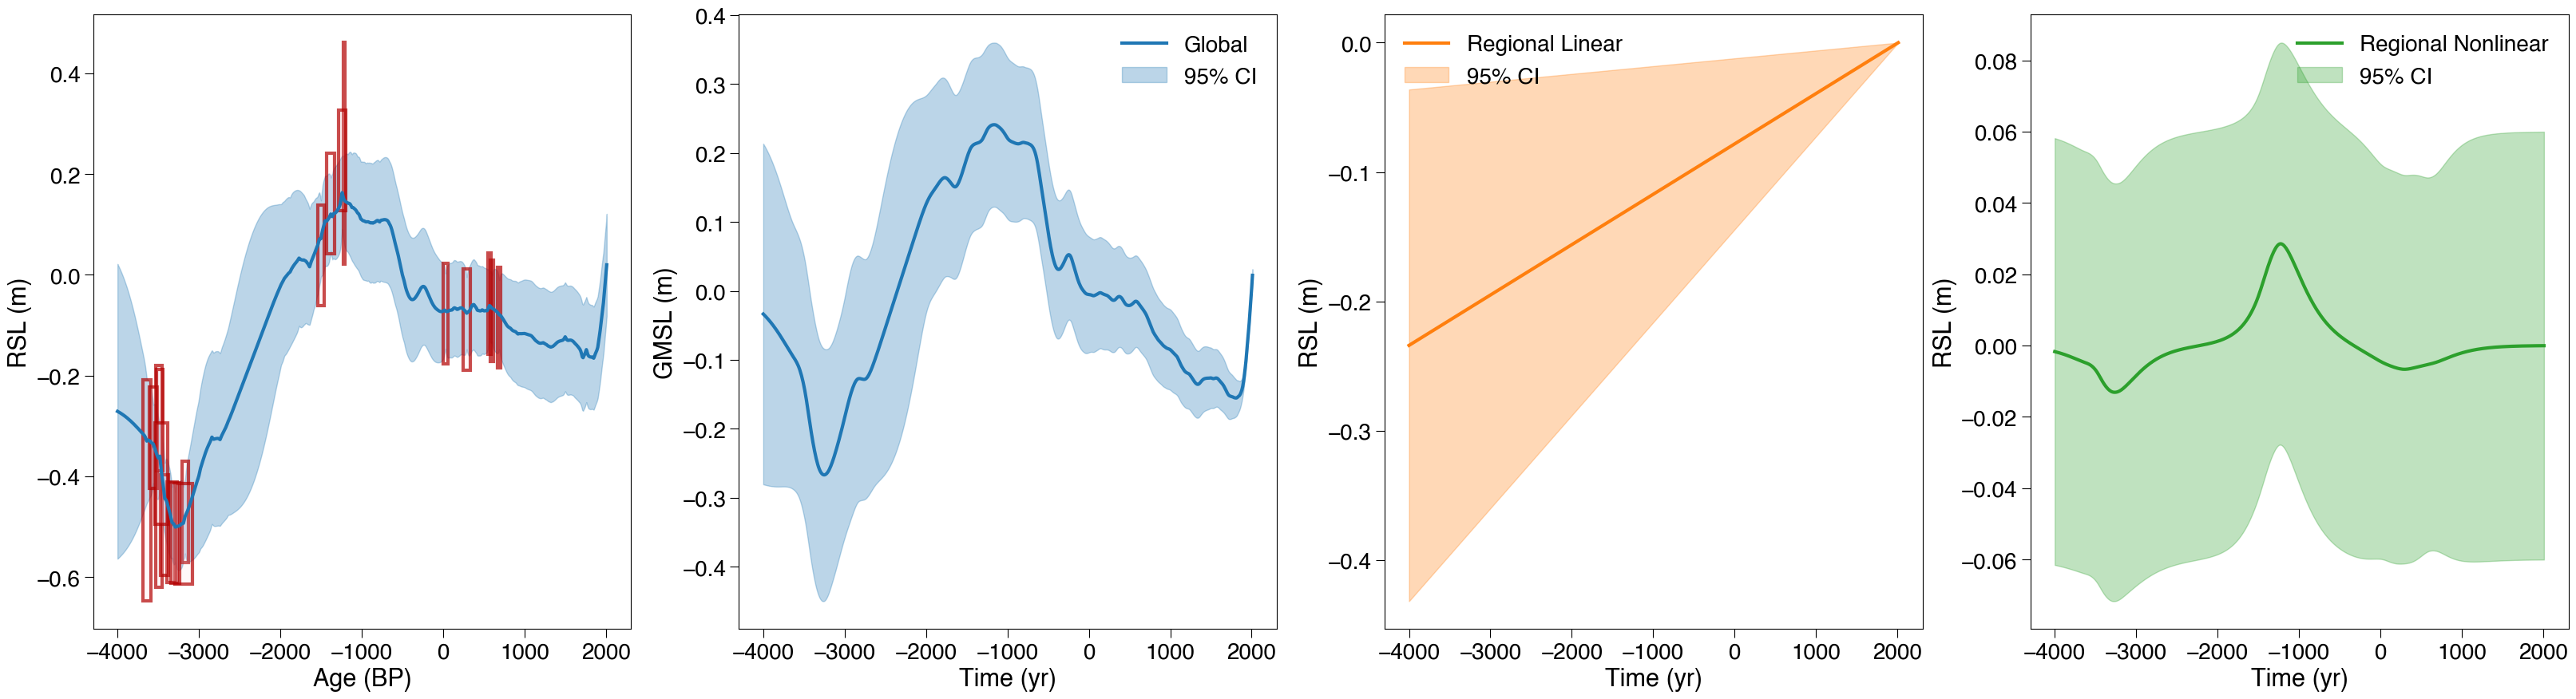

In [27]:
plt.figure(figsize=(40,10))
ax = plt.subplot(141)
data_index = np.sum(np.abs(X_all[:,1:]-data_point),axis=1)<1e-3
PSTHM.plotting.plot_uncertainty_boxes(X_all[:,0][data_index],y_no_GIA[data_index], X_sigma[data_index]*2,y_sigma[data_index]*2,ax=ax)
plt.plot(pred_matrix[:,0],y_mean.detach().numpy(),'C0',linewidth=3,label='Mean Prediction')
plt.fill_between(pred_matrix[:,0],y_mean.detach().numpy()-2*y_std.detach().numpy(),y_mean.detach().numpy()+2*y_std.detach().numpy(),color='C0',alpha=0.3,label='95% CI')
plt.subplot(142)
plt.plot(test_age,global_mean.detach().numpy(),'C0',linewidth=3,label='Global')
plt.fill_between(test_age,global_mean.detach().numpy()-2*global_std.detach().numpy(),global_mean.detach().numpy()+2*global_std.detach().numpy(),color='C0',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('GMSL (m)')
plt.legend()
plt.subplot(143)
plt.plot(test_age,regional_linear_mean.detach().numpy(),'C1',linewidth=3,label='Regional Linear')
plt.fill_between(test_age,regional_linear_mean.detach().numpy()-2*regional_linear_std.detach().numpy(),regional_linear_mean.detach().numpy()+2*regional_linear_std.detach().numpy(),color='C1',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (m)')
plt.legend()
plt.subplot(144)
plt.plot(test_age,regional_nl_mean.detach().numpy(),'C2',linewidth=3,label='Regional Nonlinear')
plt.fill_between(test_age,regional_nl_mean.detach().numpy()-2*regional_nl_std.detach().numpy(),regional_nl_mean.detach().numpy()+2*regional_nl_std.detach().numpy(),color='C2',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (m)')
plt.legend()

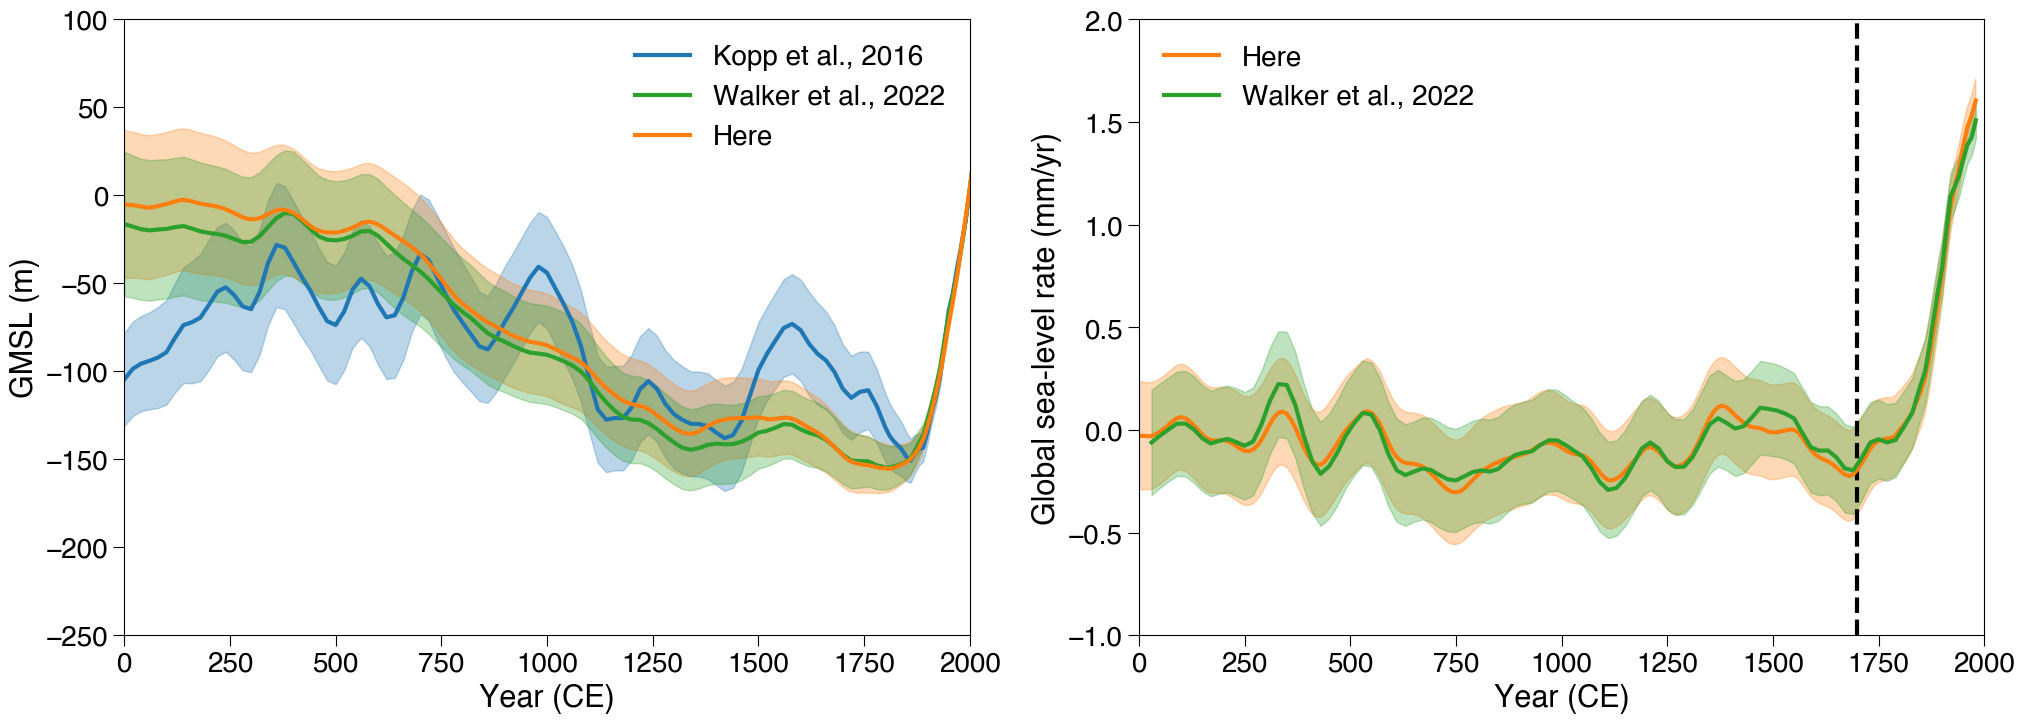

In [39]:

kopp2016 = pd.read_excel('IFILES/Kopp2016.xls',sheet_name=1,skiprows=2)
kopp2016_cov = pd.read_excel('IFILES/Kopp2016.xls',sheet_name=6,skiprows=2).iloc[:,1:]
walker_2022 = pd.read_excel('IFILES/Walker et al 2022 GSL.xlsx',sheet_name = 0,header=None)
walker_2022_rate = pd.read_excel('IFILES/Walker et al 2022 GSL.xlsx',sheet_name = 1,header=None)

plt.figure(figsize=(24,8))
plt.subplot(121)
plt.plot(kopp2016['Year'].values, kopp2016['mm'].values,label='Kopp et al., 2016',lw=3)
plt.plot(walker_2022.iloc[:,0].values,walker_2022.iloc[:,1].values,label='Walker et al., 2022',lw=3,color='C2')
plt.fill_between(kopp2016['Year'].values,kopp2016['mm'].values+1*kopp2016['1s'],kopp2016['mm'].values-1*kopp2016['1s'].values,alpha=0.3,color='C0')
plt.plot(test_age,global_mean.detach().numpy()*1000,'C1',linewidth=3,label='Here')
plt.fill_between(test_age,(global_mean.detach().numpy()-1*global_std.detach().numpy())*1000,(global_mean.detach().numpy()+1*global_std.detach().numpy())*1000,color='C1'
                ,alpha=0.3)
plt.fill_between(walker_2022.iloc[:,0],walker_2022.iloc[:,1]+walker_2022.iloc[:,2],walker_2022.iloc[:,1]-walker_2022.iloc[:,2],alpha=0.3,color='C2')

plt.legend()
plt.xlabel('Year (CE)')
plt.ylabel('GMSL (m)')
plt.xlim(0,2000)
plt.ylim(-250,100)

plt.subplot(122)
rsl_time,rsl_rate,rsl_rate_sd = PSTHM.post.cal_rate_var(pred_matrix[:,0].detach().numpy(),global_var.detach().numpy(),global_mean.detach().numpy(),difftimestep=60)
kopp2016_rsl_time,kopp2016_rsl_rate,kopp2016_rsl_rate_sd = PSTHM.post.cal_rate_var(kopp2016['Year'].values,kopp2016_cov,kopp2016['mm'])
# plt.plot(kopp2016_rsl_time,kopp2016_rsl_rate,label='Kopp et al., 2016',lw=3)
# plt.fill_between(kopp2016_rsl_time,kopp2016_rsl_rate+2*kopp2016_rsl_rate_sd,kopp2016_rsl_rate-2*kopp2016_rsl_rate_sd,alpha=0.3,color='C0')

plt.plot(rsl_time,rsl_rate*1000,label='Here',lw=3,color='C1')
plt.plot(walker_2022_rate.iloc[:,0].values,walker_2022_rate.iloc[:,1].values,label='Walker et al., 2022',lw=3,color='C2')
plt.fill_between(rsl_time,(rsl_rate-rsl_rate_sd)*1000,(rsl_rate+rsl_rate_sd)*1000,alpha=0.3,color='C1')
plt.fill_between(walker_2022_rate.iloc[:,0],walker_2022_rate.iloc[:,1]+walker_2022_rate.iloc[:,2],walker_2022_rate.iloc[:,1]-walker_2022_rate.iloc[:,2],alpha=0.3,color='C2')
plt.legend()
plt.vlines(1700,-1,2,color='k',linestyle='--',lw=3)
plt.ylim(-1,2)
plt.xlim(0,2000)
plt.xlabel('Year (CE)')
plt.ylabel('Global sea-level rate (mm/yr)');